<a href="https://colab.research.google.com/github/henriquehorton/Python_aprendendo/blob/master/agoritmo_deteccao_ptx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O algoritmo terá a seguinte o seguinte fluxograma:

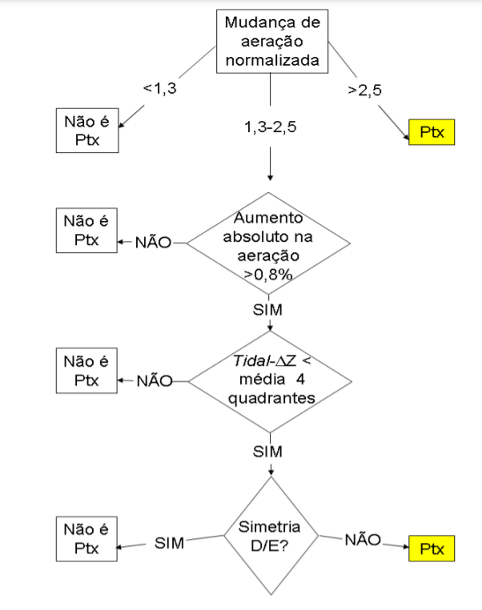

Explicar cada uns dos elementos do fluxograma (Decisões e Ações)

##Conectar ao goole driver

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Mandar scripts para diretorio raiz

In [2]:
!cp /content/drive/MyDrive/UFABC/IC/ptx_detect/utils_txt_vol.py /content/

## Importando bibliotecas

In [3]:
import bz2
import pickle
import matplotlib.pyplot as plt
import utils_txt_vol as txt
from scipy.signal import sosfiltfilt, butter
import numpy as np

In [4]:
# Permite não ter que reiniciar o kernel para testar mudanças nos arquivos *.py
%load_ext autoreload
%autoreload 2

## Lendo arquivo

In [136]:
nome = '/content/drive/MyDrive/UFABC/IC/ptx_detect/dados/ptx2.bz2' # Caminho do drive (colab)
# nome = 'dados/ptx2.bz2'
infile = bz2.BZ2File(nome, 'rb')
data = pickle.load(infile)
infile.close()

In [137]:
def data_filter(data, order = 8, fs = 3):
    # butter(ordem, freq_corte)
    sos = butter(order, fs, output='sos', fs=50)
    for idx in range(1024):
        data.vol[:,idx] = sosfiltfilt(sos, data.vol[:,idx])
    data.plets = [ np.sum(x) for x in data.vol]
    return data

In [138]:
data_filtrado = txt.data_copy(data)
data_filtrado = data_filter(data_filtrado, fs=2)

In [139]:
ins_marks = [idx for idx,x in enumerate(data.ins_mark) if x != 0]
exp_marks = [idx for idx,x in enumerate(data.exp_mark) if x != 0]

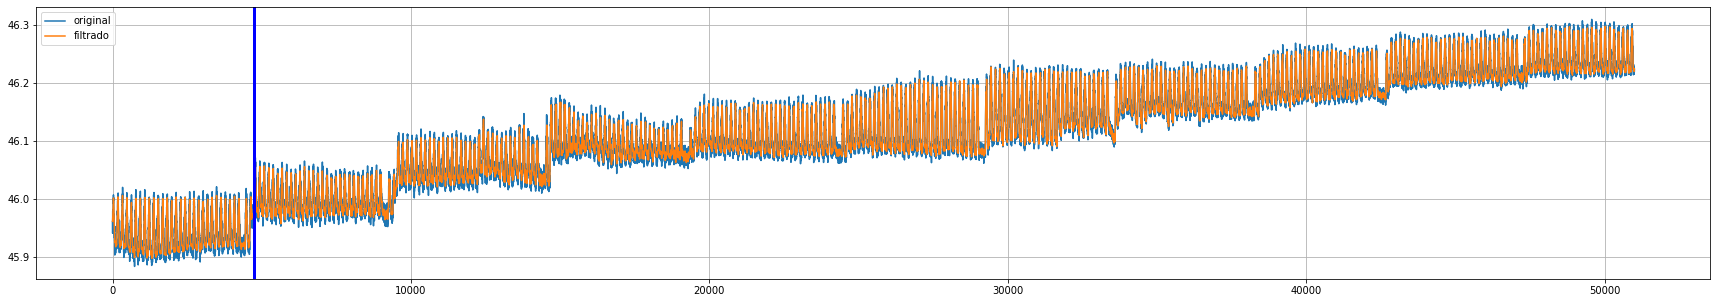

In [287]:
intervalo_max = 50000 + 1000
intervalo_min = 000 - 1000
plt.figure(figsize=(30,5))
plt.plot(data.plets[intervalo_min:intervalo_max],label='original')
plt.plot(data_filtrado.plets[intervalo_min:intervalo_max],label='filtrado')
for i in ins_marks:
  if i <= numbers_frames:
    plt.gca().axvline(x=4742-intervalo_min, color = "red",linewidth=3)
for e in exp_marks:
  if e <= numbers_frames:
    plt.gca().axvline(x=4742-intervalo_min, color = "blue",linewidth=3)
plt.grid()
plt.legend()
plt.show()

##Carregando imagens

In [141]:
dir_matrizes_sem_atlas = '/content/drive/MyDrive/UFABC/IC/ptx_detect/matrizes/sem_atlas/Pig_0/' # sem atlas #Caminho do drive (colab)
# dir_matrizes_sem_atlas = 'matrizes/sem_atlas/Pig_0/' # sem atlas

In [142]:
wien = txt.my_wiener(dir_matrizes_sem_atlas)

In [143]:
wien.load_data(data)

##Mudança de Aeração Normalizada

In [144]:
import pandas as pd

Cada Frame do pulmão será dividida em 4 quadrantes Iguais que serão identificadas pelas seguintes variáveis:

Q1: Superior Direito - [ :16, :16]

Q2: Superior Esquerdo - [ :16,16: ]

Q3: Inferior Direito - [16: , :16]

Q4: Inferior Esquerdo - [16: ,16: ]

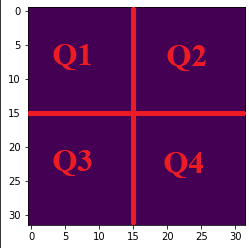

In [314]:
# df com as marcações da inspiração e expiração com seus respectivos frames
df = pd.DataFrame({'Plets': (data.plets),
              'Mark ins': data.ins_mark,
              'Mark exp': data.exp_mark,
              'Resultado':None})
df.index = np.arange(1, len(df)+1)

A coluna 'Resultado' do dataFrame irá indicar três tipos de valores:
* 1 = detecção de ptx
* 0 = ptx descartado
* None = ptx em análise

In [315]:
def mudanca_normalizada(df):
  df_frame_ins = df.copy()
  df_frame_ins = df_frame_ins.loc[df_frame_ins['Mark ins'] != 0] # Usar apenas frames de ins (aeração)

  for i in df_frame_ins.index:
    image = wien.get_image32(i).mean()
    q1 = wien.get_image32(i)[:16,:16].mean()/image
    q2 = wien.get_image32(i)[:16,16:].mean()/image
    q3 = wien.get_image32(i)[16:,:16].mean()/image
    q4 = wien.get_image32(i)[16:,16:].mean()/image
    # Atribuir valores 1 e 0 para o dataframe
    if (q1 or q2 or q3 or q4) >2.5:
      mask = df_frame_ins.index==i
      df_frame_ins.loc[mask, 'Resultado'] = 1
    elif (q1 and q2 and q3 and q4) < 1.3:
      mask = df_frame_ins.index==i
      df_frame_ins.loc[mask, 'Resultado'] = 0

  return df_frame_ins

Como podemos ver no dataframe e no gráfico o ptx começa no frame 4742

In [316]:
df_mudanca_normalizada = mudanca_normalizada(df)
df_mudanca_normalizada.loc[df_mudanca_normalizada['Resultado']==1].head()

,Plets,Mark ins,Mark exp,Resultado
4742,45.986021,1.0,0.0,1
4892,45.976629,1.0,0.0,1
5042,45.979111,1.0,0.0,1
5192,45.976702,1.0,0.0,1
5342,45.967674,1.0,0.0,1


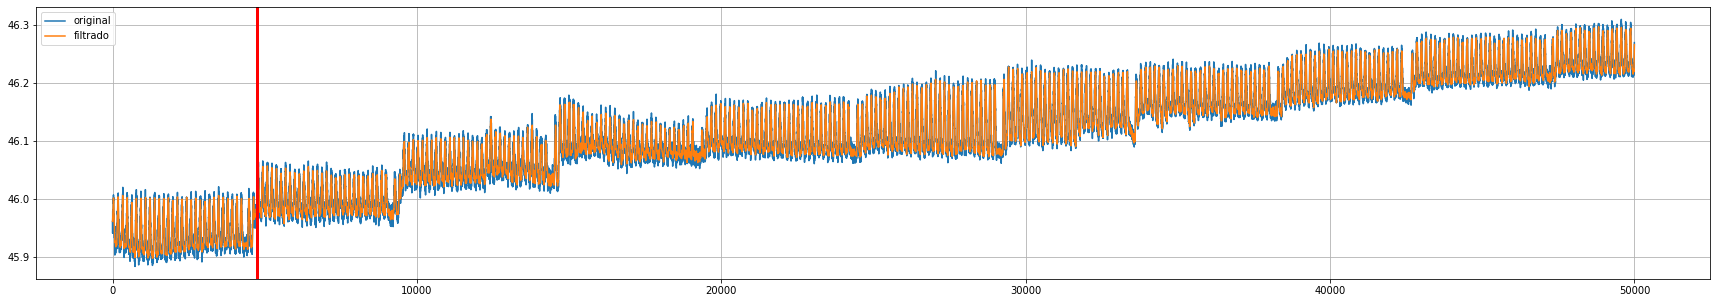

In [293]:
intervalo_max = 50000 
intervalo_min = 0 
plt.figure(figsize=(30,5))
plt.plot(data.plets[intervalo_min:intervalo_max],label='original')
plt.plot(data_filtrado.plets[intervalo_min:intervalo_max],label='filtrado')
for i in ins_marks:
  if i <= numbers_frames:
    plt.gca().axvline(x=4742-intervalo_min, color = "red",linewidth=3)
# for e in exp_marks:
#   if e <= numbers_frames:
#     plt.gca().axvline(x=4742-intervalo_min, color = "blue",linewidth=3)
plt.grid()
plt.legend()
plt.show()

In [317]:
def aumento_absoluto(df, percentul = 0.008):
  df_frame_absoluto = df.copy()
  df_frame_absoluto = df_frame_absoluto[(df_frame_absoluto['Resultado'] != 0)&(df_frame_absoluto['Resultado']!=1)] #Utilizar apenas frames sem conclusões (None)
  for i in df_frame_absoluto.index:
    aumento_abs_q1 = (wien.get_image32(i)[:16,:16].mean()-wien.get_image32(ins_marks[0])[:16,:16].mean())/wien.get_image32(ins_marks[0])[:16,:16].mean()
    aumento_abs_q2 = (wien.get_image32(i)[:16,16:].mean()-wien.get_image32(ins_marks[0])[:16,16:].mean())/wien.get_image32(ins_marks[0])[:16,16:].mean()
    aumento_abs_q3 = (wien.get_image32(i)[16:,:16].mean()-wien.get_image32(ins_marks[0])[16:,:16].mean())/wien.get_image32(ins_marks[0])[16:,:16].mean()
    aumento_abs_q4 = (wien.get_image32(i)[16:,16:].mean()-wien.get_image32(ins_marks[0])[16:,16:].mean())/wien.get_image32(ins_marks[0])[16:,16:].mean()
    # Atribuir valores 1 e 0 para o dataframe
    if (aumento_abs_q1 or aumento_abs_q2 or aumento_abs_q3 or aumento_abs_q4) <= percentul: 
      mask = df_frame_absoluto.index==i
      df_frame_absoluto.loc[mask, 'Resultado'] = 0
  return df_frame_absoluto

Não é conclusivo, mas o algoritmo indica término do ptx no frame 82882

In [323]:
df_aumento_absoluto = aumento_absoluto(df_mudanca_normalizada)
df_aumento_absoluto.tail(8)

,Plets,Mark ins,Mark exp,Resultado
76277,46.259668,1.0,0.0,None
76427,46.242233,1.0,0.0,None
82882,45.815714,1.0,0.0,0
83033,45.817646,1.0,0.0,0
83183,45.786222,1.0,0.0,0
83333,45.789619,1.0,0.0,0
83483,45.806441,1.0,0.0,0
83633,45.794647,1.0,0.0,0


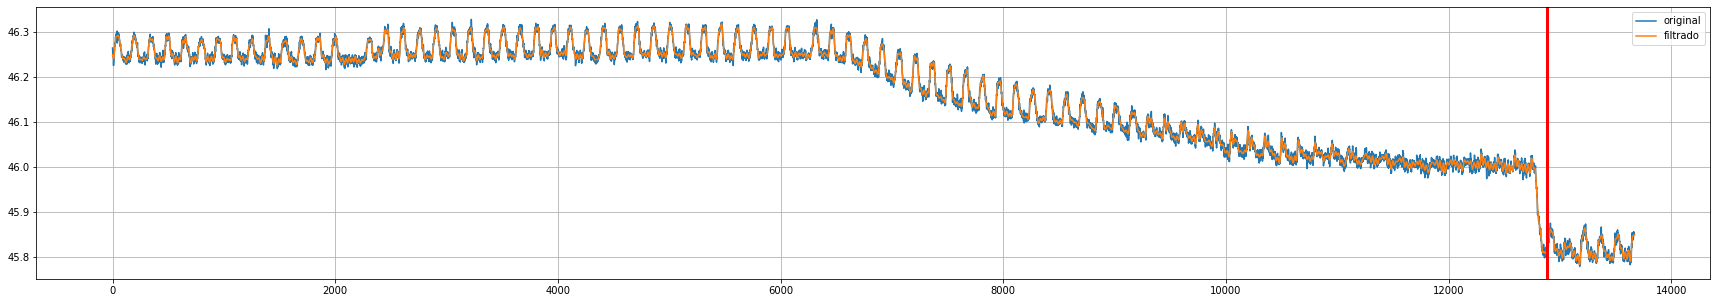

In [299]:
intervalo_max = 90000 
intervalo_min = 70000 
plt.figure(figsize=(30,5))
plt.plot(data.plets[intervalo_min:intervalo_max],label='original')
plt.plot(data_filtrado.plets[intervalo_min:intervalo_max],label='filtrado')
for i in ins_marks:
  if i <= numbers_frames:
    plt.gca().axvline(x=82882-intervalo_min, color = "red",linewidth=3)
# for e in exp_marks:
#   if e <= numbers_frames:
#     plt.gca().axvline(x=4742-intervalo_min, color = "blue",linewidth=3)
plt.grid()
plt.legend()
plt.show()

In [327]:
def tidal(df, df_mudanca_absoluta):
  df_tidal = df_aumento_absoluto.copy()
  df_tidal =  df_tidal[df_tidal['Resultado'] != 0]# Utilizar apenas frames sem conclusões (None)
  # Criando dois dataframes separados com pares de marcações de ins e exp
  df_marks = df.copy()
  df_marks_ins = df_marks.loc[df_marks['Mark ins'] != 0]
  df_marks_ins = df_marks_ins.drop(df_marks_ins.tail(1).index)# iliminei o ultimo valor sem par
  df_marks_exp = df_marks.loc[df_marks['Mark exp'] != 0]

  for i,e in zip(df_marks_ins.index,df_marks_exp.index): #chamando início e término da ins e exp do mesmo ciclo respiratório
    if ((df_tidal.index.values==i)^0).sum() == 1: # Só serão analisados os frames que ainda não obtiveram nenhuma classificação (none)
      tidal = (wien.get_image32(e)-wien.get_image32(i)).mean()
      tidal_q1 = (wien.get_image32(e)[:16,:16]-wien.get_image32(i)[:16,:16]).mean()
      tidal_q2 = (wien.get_image32(e)[:16,16:]-wien.get_image32(i)[:16,16:]).mean()
      tidal_q3 = (wien.get_image32(e)[16:,:16]-wien.get_image32(i)[16:,:16]).mean()
      tidal_q4 = (wien.get_image32(e)[16:,16:]-wien.get_image32(i)[16:,16:]).mean()
      # Atribuir valores 1 e 0 para o dataframe
      if(tidal_q1 or tidal_q2 or tidal_q3 or tidal_q4) < tidal:
        mask = df_tidal.index==i
        df_tidal.loc[mask, 'Resultado'] = 0
  return df_tidal

Apesar de ser possivel encontrar visualmente um ptx no intervalo (61454-76427) do gráfico, o algoritmo não descarta e não afirma a possibilidade de um ptx.

In [332]:
df_tidal = tidal(df, df_mudanca_absoluta)
df_tidal.head(2)

,Plets,Mark ins,Mark exp,Resultado
61454,46.230008,1.0,0.0,None
66559,46.248667,1.0,0.0,None


In [329]:
df_tidal.tail(2)

,Plets,Mark ins,Mark exp,Resultado
76277,46.259668,1.0,0.0,None
76427,46.242233,1.0,0.0,None


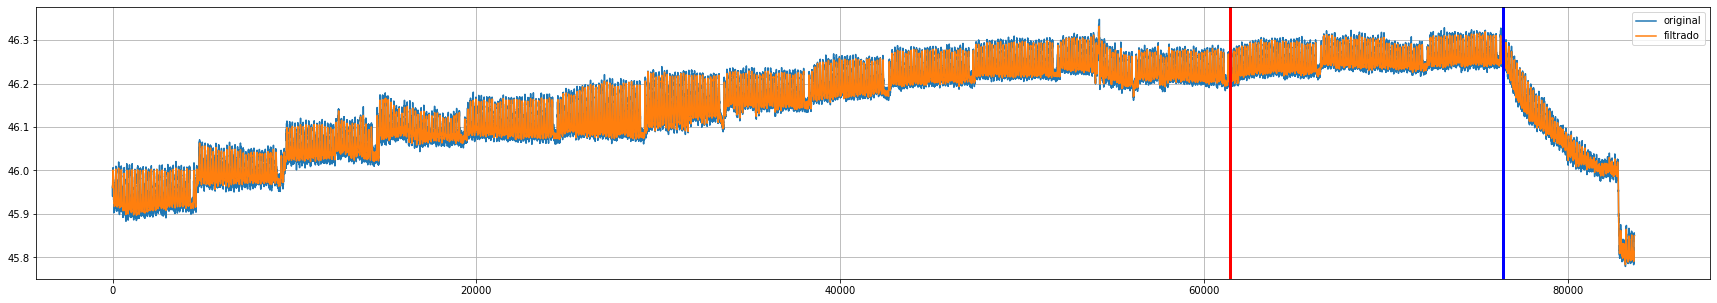

In [331]:
intervalo_max = 90000 
intervalo_min = 10000 - 10000
plt.figure(figsize=(30,5))
plt.plot(data.plets[intervalo_min:intervalo_max],label='original')
plt.plot(data_filtrado.plets[intervalo_min:intervalo_max],label='filtrado')
for i in ins_marks:
  if i <= numbers_frames:
    plt.gca().axvline(x=61454-intervalo_min, color = "red",linewidth=3)
for e in exp_marks:
  if e <= numbers_frames:
    plt.gca().axvline(x=76427-intervalo_min, color = "blue",linewidth=3)
plt.grid()
plt.legend()
plt.show()